# 파일구조

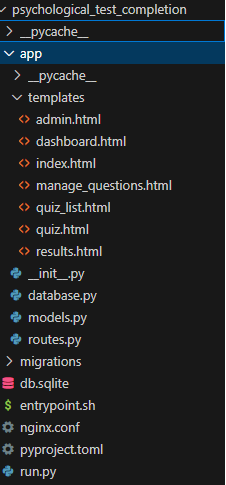



* psycological_test_completion: 프로젝트의 루트 디렉토리
* app: 애플리케이션의 주요 코드가 있는 폴더
  * database.py:데이터베이스 연결 및 설정을 관리
  * models.py:데이터베이스 모델(테이블 구조)을 정의
  * routes.py:애플리케이션의 URL 라우팅과 뷰 함수를 정의
  * __init__.py: 애플리케이션을 초기화 구성
* templates:HTML 템플릿 파일들이 있는 폴더입니다.
  * admin.html:관리자 페이지 템플릿
  * dashboard.html:대시보드 페이지 템플릿
  * index.html:메인 페이지 템플릿
  * manage_question.html:질문 관리 페이지 템플릿
  * quiz.html:퀴즈 페이지 템플릿
  * quiz_list.html:퀴즈 목록 페이지 템플릿
  * results.html:결과 페이지 템플릿
*run.py: 애플리케이션을 실행하는 스크립트입니다.






# 코드분석

app/__init__.py

In [ ]:
from flask import Flask
from flask_migrate import Migrate
from flask.cli import with_appcontext
import os
import click
from .database import db
from .models import Question, Admin, Participant  # Question 모델 임포트
from werkzeug.security import generate_password_hash
from datetime import datetime, timedelta


def create_app():
    app = Flask(__name__)
    app.secret_key = "oz_coding_secret"

    # 데이터베이스 파일 경로 설정 및 앱 설정
    basedir = os.path.abspath(os.path.dirname(os.path.dirname(__file__)))
    dbfile = os.path.join(basedir, "db.sqlite")
    app.config["SQLALCHEMY_DATABASE_URI"] = "sqlite:///" + dbfile
    app.config["SQLALCHEMY_TRACK_MODIFICATIONS"] = False

    # 데이터베이스 및 마이그레이션 초기화
    db.init_app(app)
    migrate = Migrate(app, db)

    # 라우트(블루프린트) 등록
    from .routes import main as main_blueprint
    from .routes import admin as admin_blueprint

    app.register_blueprint(main_blueprint)
    app.register_blueprint(admin_blueprint)

    # 초기화 명령어 정의
    def add_initial_questions():
        initial_questions = [
            "오즈코딩스쿨에 대해서 알고 계신가요?",
            "프론트엔드 과정에 참여하고 계신가요?",
            "전공자 이신가요?",
            "프로젝트를 진행해보신적 있으신가요?",
            "개발자로 일한 경력이 있으신가요?",
        ]
        yesterday = datetime.utcnow() - timedelta(days=1)  # 어제 날짜 계산

        # 관리자 계정 추가 로직, 비밀번호 해시 처리 적용
        existing_admin = Admin.query.filter_by(username="admin").first()
        if not existing_admin:
            hashed_password = generate_password_hash("0000")  # 비밀번호를 해시 처리
            new_admin = Admin(username="admin", password=hashed_password)
            db.session.add(new_admin)

        participants_without_created_at = Participant.query.filter(
            Participant.created_at == None
        ).all()

        for participant in participants_without_created_at:
            participant.created_at = yesterday

        for question_content in initial_questions:
            existing_question = Question.query.filter_by(
                content=question_content
            ).first()
            if not existing_question:
                new_question = Question(content=question_content)
                db.session.add(new_question)
        questions = Question.query.all()
        for question in questions:
            question.order_num = question.id
            question.is_active = True  # 모든 질문을 활성화 상태로 설정
        db.session.commit()

    @click.command("init-db")
    @with_appcontext
    def init_db_command():
        db.create_all()
        add_initial_questions()
        click.echo("Initialized the database.")

    app.cli.add_command(init_db_command)

    return app


app/database.py

In [ ]:
from flask_sqlalchemy import SQLAlchemy

db = SQLAlchemy()


app/models.py

In [ ]:
from .database import db
from datetime import datetime

class Participant(db.Model):
    __tablename__ = "participant"
    id = db.Column(db.Integer, primary_key=True)
    name = db.Column(db.String(50))
    age = db.Column(db.Integer)
    gender = db.Column(db.String(10))
    created_at = db.Column(db.DateTime, default=datetime.utcnow)


class Admin(db.Model):
    __tablename__ = "admin"
    id = db.Column(db.Integer, primary_key=True)
    username = db.Column(db.String(50))
    password = db.Column(db.String(50))


class Question(db.Model):
    __tablename__ = "question"
    id = db.Column(db.Integer, primary_key=True)
    content = db.Column(db.String(255))
    order_num = db.Column(db.Integer, default=0)
    is_active = db.Column(db.Boolean, default=True)


class Quiz(db.Model):
    __tablename__ = "quiz"
    id = db.Column(db.Integer, primary_key=True)
    participant_id = db.Column(db.Integer, db.ForeignKey("participant.id"))
    question_id = db.Column(db.Integer, db.ForeignKey("question.id"))
    chosen_answer = db.Column(db.String(255))

    participant = db.relationship("Participant", backref="quizzes")
    question = db.relationship("Question", backref="quizzes")

app/route.py

In [ ]:
from flask import (
    jsonify,
    render_template,
    request,
    Blueprint,
    redirect,
    url_for,
    flash,
    session,
)
from werkzeug.security import check_password_hash
from .models import Question, Participant, Quiz, Admin
from .database import db
import plotly.express as px
import pandas as pd
import plotly
import json
from sqlalchemy import func, extract
import plotly.graph_objs as go
from plotly.offline import plot
from datetime import datetime
# 'main'이라는 이름의 Blueprint 객체 생성
main = Blueprint("main", __name__)
admin = Blueprint("admin", __name__, url_prefix="/admin/")


@main.route("/", methods=["GET"])
def home():
    # 참여자 정보 입력 페이지를 렌더링합니다. 그 결과를 클라이언트에 반환합니다.
    return render_template("index.html")

#/participants URL에 대한 POST 요청을 처리하는 라우트를 정의하고 Participant
#모델의 새인스턴스를 생성해서 참가자 정보를 저장합니다.
#Json형식으로 리다이렉트로 반환합니다.
@main.route("/participants", methods=["POST"])
def add_participant():
    data = request.get_json()
    new_participant = Participant(
        name=data["name"], age=data["age"], gender=data["gender"] , created_at=datetime.utcnow()
    )
    db.session.add(new_participant)
    db.session.commit()

    # 리다이렉션 URL과 참여자 ID를 JSON 응답으로 전송
    return jsonify(
        {"redirect": url_for("main.quiz"), "participant_id": new_participant.id}
    )

#/quiz URL접근합니다. if문을 사용해서 participant_id가 있는지 확인하고 있으면 데이터
#베이스에서 모든 질문을 조회하고 아니면 홈페이지로 리다이렉트합니다.
#quiz.html 템플릿을 렌더링하고 질문리스트를 템플릿에 전달합니다.
@main.route("/quiz")
def quiz():
    # 퀴즈 페이지를 렌더링합니다. 참여자 ID 쿠키가 필요합니다.
    participant_id = request.cookies.get("participant_id")
    if not participant_id:
        # 참여자 ID가 없으면, 홈페이지로 리다이렉션합니다.
        return redirect(url_for("main.home"))

    questions = Question.query.all()
    questions_list = [question.content for question in questions]
    return render_template("quiz.html", questions=questions_list)

#/submit URL에 POST요청을 보냅니다. participant_id를 쿠키에 요청을 합니다.
#if문을 사용하여 participant_id가 있는지 없는지 구분합니다.
#participant_id가 있다면 Json데이터로 리스트에 담아서 데이터를 파싱합니다.
#session을 추가하고 커밋합니다. 성공메시지와  결과 페이지로의 리다이렉트를
#URL을 포함한 json응답을반환합니다.
@main.route("/submit", methods=["POST"])
def submit():
    # 참여자 ID가 필요합니다.
    participant_id = request.cookies.get("participant_id")
    if not participant_id:
        return jsonify({"error": "Participant ID not found"}), 400

    data = request.json
    quizzes = data.get("quizzes", [])

    for quiz in quizzes:
        question_id = quiz.get("question_id")
        chosen_answer = quiz.get("chosen_answer")

        # 새 Quiz 인스턴스 생성
        new_quiz_entry = Quiz(
            participant_id=participant_id,
            question_id=question_id,
            chosen_answer=chosen_answer,
        )
        # 데이터베이스에 추가
        db.session.add(new_quiz_entry)

    # 변경 사항 커밋
    db.session.commit()
    return jsonify(
        {
            "message": "Quiz answers submitted successfully.",
            "redirect": url_for("main.show_results"),
        }
    )

#/questions URL에 GET 요청을 보냅니다
#DB에서 활성화된 질문들을 가져오고 정렬합니다.
#가져온 정보를 id, content, order_num에 저장을 해서 새로운 리스트를 만듭니다.
@main.route("/questions")
def get_questions():
    # is_active가 True인 질문만 선택하고, order_num에 따라 정렬
    questions = (
        Question.query.filter(Question.is_active == True)
        .order_by(Question.order_num)
        .all()
    )
    questions_list = [
        {
            "id": question.id,
            "content": question.content,
            "order_num": question.order_num,
        }
        for question in questions
    ]
    return jsonify(questions=questions_list)


@main.route("/results")
def show_results():
    # 데이터베이스에서 데이터 조회
    participants_query = Participant.query.all()
    quizzes_query = Quiz.query.join(Question).all()

    # pandas DataFrame으로 변환
    participants_data = [
        {"age": participant.age, "gender": participant.gender}
        for participant in participants_query
    ]
    quizzes_data = [
        {
            "question_id": quiz.question_id,
            "chosen_answer": quiz.chosen_answer,
            "participant_age": quiz.participant.age,
        }
        for quiz in quizzes_query
    ]

    participants_df = pd.DataFrame(participants_data)
    quizzes_df = pd.DataFrame(quizzes_data)

    # Plotly 시각화 생성
    # 예시 1: 나이별 분포 (도넛 차트)
    fig_age = px.pie(
        participants_df,
        names="age",
        hole=0.3,
        title="Age Distribution",
        color_discrete_sequence=px.colors.sequential.RdBu,
        labels={"age": "Age Group"},
    )
    fig_age.update_traces(textposition="inside", textinfo="percent+label")

    fig_gender = px.pie(
        participants_df,
        names="gender",
        hole=0.3,
        title="Gender Distribution",
        color_discrete_sequence=px.colors.sequential.Purp,
        labels={"gender": "Gender"},
    )
    fig_gender.update_traces(textposition="inside", textinfo="percent+label")

    quiz_response_figs = {}

    # 각 질문 ID별로 반복하여 그래프 생성
    for question_id in quizzes_df["question_id"].unique():
        filtered_df = quizzes_df[quizzes_df["question_id"] == question_id]
        fig = px.histogram(
            filtered_df,
            x="chosen_answer",
            title=f"Question {question_id} Responses",
            color="chosen_answer",
            barmode="group",
            category_orders={"chosen_answer": ["yes", "no"]},  # 카테고리 순서 지정
            color_discrete_map={"yes": "RebeccaPurple", "no": "LightSeaGreen"},
        )  # 컬러 매핑
        fig.update_layout(
            xaxis_title="Chosen Answer",
            yaxis_title="Count",
            plot_bgcolor="rgba(0,0,0,0)",  # 배경색 투명
            paper_bgcolor="rgba(0,0,0,0)",  # 전체 배경색 투명
            font=dict(family="Courier New, monospace", size=18, color="#7f7f7f"),
            title_font=dict(
                family="Helvetica, Arial, sans-serif", size=22, color="RebeccaPurple"
            ),
        )
        fig.update_traces(marker_line_width=1.5, opacity=0.6)  # 투명도와 테두리 두께 조정

        # 생성된 그래프를 딕셔너리에 저장
        quiz_response_figs[f"question_{question_id}"] = fig
    age_quiz_response_figs = {}

    # 나이대를 구분하는 함수
    def age_group(age):
        if age == 'teenage':
            return "10s"
        elif age == 'twenty':
            return "20s"
        elif age == 'thirty':
            return "30s"
        elif age == 'forty':
            return "40s"
        elif age == 'fifties':
            return "50s"
        else:
            return "60s+"

    # 나이대 그룹 열 추가
    quizzes_df["age_group"] = quizzes_df["participant_age"].apply(age_group)

    # 각 질문 ID와 나이대별로 대답 분포를 시각화
    for question_id in quizzes_df["question_id"].unique():
        filtered_df = quizzes_df[quizzes_df["question_id"] == question_id]
        fig = px.histogram(
            filtered_df,
            x="age_group",
            color="chosen_answer",
            barmode="group",
            title=f"Question {question_id} Responses by Age Group",
            labels={"age_group": "Age Group", "chosen_answer": "Chosen Answer"},
            category_orders={"age_group": ["10s", "20s", "30s", "40s", "50s+"]},
        )

        # 스타일 조정
        fig.update_layout(
            xaxis_title="Age Group",
            yaxis_title="Count",
            plot_bgcolor="rgba(0,0,0,0)",
            paper_bgcolor="rgba(0,0,0,0)",
            font=dict(family="Courier New, monospace", size=18, color="#7f7f7f"),
            title_font=dict(
                family="Helvetica, Arial, sans-serif", size=22, color="RebeccaPurple"
            ),
        )
        fig.update_traces(marker_line_width=1.5, opacity=0.6)
        age_quiz_response_figs[f"question_{question_id}"] = fig
    # 딕셔너리에 저장된 그래프들을 JSON으로 변환
    graphs_json = json.dumps(
        {
            "age_distribution": fig_age,
            "gender_distribution": fig_gender,
            "quiz_responses": quiz_response_figs,
            "age_quiz_response_figs": age_quiz_response_figs,
        },
        cls=plotly.utils.PlotlyJSONEncoder,
    )

    # 데이터를 results.html에 전달
    return render_template("results.html", graphs_json=graphs_json)

#관리자 로그인 페이지에 접근합니다.
#GET요청인 경우 로그인 페이지를 렌더링하여 반환합니다.
#사용자가 username과 password를 입력하면 POST요청을 합니다.
#이름과 비밀번호를 확인 한 후 있으면 session에 로그인 상태를 저장하고
#dashboard로 리다이렉트 시킵니다.
#이름과 비밀번호가 없으면 에러메세지를 보여줍니다.
@admin.route("", methods=["GET", "POST"])
def login():
    if request.method == "POST":
        username = request.form["username"]
        password = request.form["password"]

        admin = Admin.query.filter_by(username=username).first()

        if admin and check_password_hash(admin.password, password):
            session["admin_logged_in"] = True
            return redirect(url_for("admin.dashboard"))
        else:
            flash("Invalid username or password")

    return render_template("admin.html")

#/logout URL을 접근합니다. session에서 admin_logged_in을 팝을해서
#로그 아웃상태로 만듭니다. 로그아웃이되면 admin.login페이지로 리다이렉트
#됩니다.
@admin.route("/logout")
def logout():
    session.pop("admin_logged_in", None)
    return redirect(url_for("admin.login"))


from functools import wraps
from flask import redirect, url_for, session

#login_required에 데코레이터를 적용합니다.admin_logged_in이 있는지 확인후
#있다면 함수를 실행하고 없다면 로그인 페이지로 리다이렉트시켜줍니다.
def login_required(f):
    @wraps(f)
    def decorated_function(*args, **kwargs):
        if "admin_logged_in" not in session:
            return redirect(url_for("admin.login", next=request.url))
        return f(*args, **kwargs)

    return decorated_function

#관리자가 dashboard 페이지에 접근합니다.
@admin.route("dashboard")
@login_required
def dashboard():
    # 날짜별 참가자 수를 계산
    participant_counts = (
        db.session.query(
            func.date(Participant.created_at).label("date"),
            func.count(Participant.id).label("count"),
        )
        .group_by("date")
        .all()
    )

    # 날짜와 참가자 수를 분리하여 리스트에 저장
    dates = [result.date for result in participant_counts]
    counts = [result.count for result in participant_counts]

    # Plotly 그래프 생성
    graph = go.Figure(go.Scatter(x=dates, y=counts, mode="lines+markers"))

    graph.update_layout(title="일자별 참가자 수", xaxis_title="날짜", yaxis_title="참가자 수")

    # Plotly 그래프를 HTML로 변환
    graph_div = plot(graph, output_type="div", include_plotlyjs=False,config = {'displayModeBar': False})

    # 생성된 HTML을 템플릿으로 전달
    return render_template("dashboard.html", graph_div=graph_div)

#/dashboard/question 페이지로 GET 요청을 하거나 POST요청을 합니다.
#POST요청일 경우 새질문 수정 폼이 제줄되면 데이터베이스에 추가해줍니다.
#기존 질문일 경우에는 데이터베이스를 업데이트해줍니다.
#질문을 저장한 후에 manage_questions.html로 템플릿을 렌더링해줍니다.
@admin.route("/dashboard/question", methods=["GET", "POST"])
@login_required
def manage_questions():
    if request.method == "POST":
        if "new_question" in request.form:
            # 새 질문 추가
            is_active = (
                "is_active" in request.form and request.form["is_active"] == "on"
            )
            new_question = Question(
                content=request.form["content"],
                order_num=request.form["order_num"],
                is_active=is_active,
            )
            db.session.add(new_question)
            db.session.commit()
        else:
            # 기존 질문 수정
            question_id = request.form["question_id"]
            question = Question.query.get(question_id)
            if question:
                is_active = (
                    "is_active" in request.form and request.form["is_active"] == "on"
                )
                question.content = request.form["content"]
                question.order_num = request.form["order_num"]
                question.is_active = is_active
                db.session.commit()

    questions = Question.query.order_by(Question.order_num).all()
    return render_template("manage_questions.html", questions=questions)

#/dashboard/list에 접근합니다
#로그인을 요청을합니다.
#데이터베이스에서 모든 퀴즈를 조회합니다. 조회된 퀴즈 목록을 quiz_list.html
#템플릿에 전달하여 렌더링해줍니다.
@admin.route("/dashboard/list")
@login_required
def quiz_list():
    quizzes = Quiz.query.all()
    return render_template("quiz_list.html", quizzes=quizzes)
